# FLD parsing and Wavefront writing

Genesis4 writes a custom field format. LUME-Genesis provides a reader for this, as well as a conversion tool to write in the [openPMD-wavefront standard](https://github.com/openPMD/openPMD-standard/blob/upcoming-2.0.0/EXT_Wavefront.md).

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Create field data

In [2]:
%%time
from genesis import Genesis4
G = Genesis4('data/basic4/cu_hxr.in')
G.input['main'].append({'type':'write', 'field':'end'})
G.nproc = 8
G.run()

CPU times: user 318 ms, sys: 91.1 ms, total: 409 ms
Wall time: 11.7 s


# Read Field h5

In [3]:
from genesis.version4 import readers
import h5py

In [4]:
FILE = G.output['field_files'][0]
FILE

'/var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmp8bbhit97/end.fld.h5'

In [5]:
h5py.is_hdf5(FILE)

True

In [6]:
with h5py.File(FILE, 'r') as h5:
    DFL, PARAM = readers.load_genesis4_fields(h5)

In [7]:
DFL.shape, DFL.dtype, PARAM

((101, 101, 544),
 dtype('complex128'),
 {'gridpoints': 101,
  'gridsize': 2e-06,
  'refposition': 0.0,
  'wavelength': 1.3789244869952112e-10,
  'slicecount': 544,
  'slicespacing': 2.7578489739904225e-08})

# Write Wavefront in openPMD-wavefront

In [8]:
from genesis.version4 import writers
import numpy as np

In [9]:
writers.write_openpmd_wavefront('genesis4_wavefront.h5', DFL, PARAM, verbose=True)

Writing wavefront (dfl data) to file genesis4_wavefront.h5


'genesis4_wavefront.h5'

In [10]:

# Read back
with h5py.File('genesis4_wavefront.h5', 'r') as h5:
    print(list(h5['data']['000000']['meshes']))
    
    g = h5['data/000000/meshes/electricField']
    print(dict(g.attrs))
    
    # Get 
    E2 = h5['data/000000/meshes/electricField/x'][:]


['electricField']
{'axisLabels': array(['x', 'y', 'z'], dtype=object), 'geometry': 'cartesian', 'gridGlobalOffset': array([-1.00000000e-04, -1.00000000e-04, -7.50134921e-06]), 'gridSpacing': array([2.00000000e-06, 2.00000000e-06, 2.75784897e-08]), 'gridUnitDimension': array([[1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0]]), 'gridUnitSI': array([1., 1., 1.]), 'photonEnergy': 8991.3696944618, 'photonEnergyUnitDimension': array([ 2,  1, -2,  0,  0,  0,  0]), 'photonEnergyUnitSI': 1.602176634e-19, 'timeOffset': 0.0, 'unitDimension': array([ 1,  1, -3, -1,  0,  0,  0])}


In [11]:
# Data is the same
np.all(E2 == DFL)

True

# Plot

Simple plot

In [12]:
# Nicer plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,8)
%config InlineBackend.figure_format = 'retina'

import numpy as np

In [13]:
# Sum over y and compute the absolute square 
dat2 = np.abs(np.sum(DFL, axis=1))**2

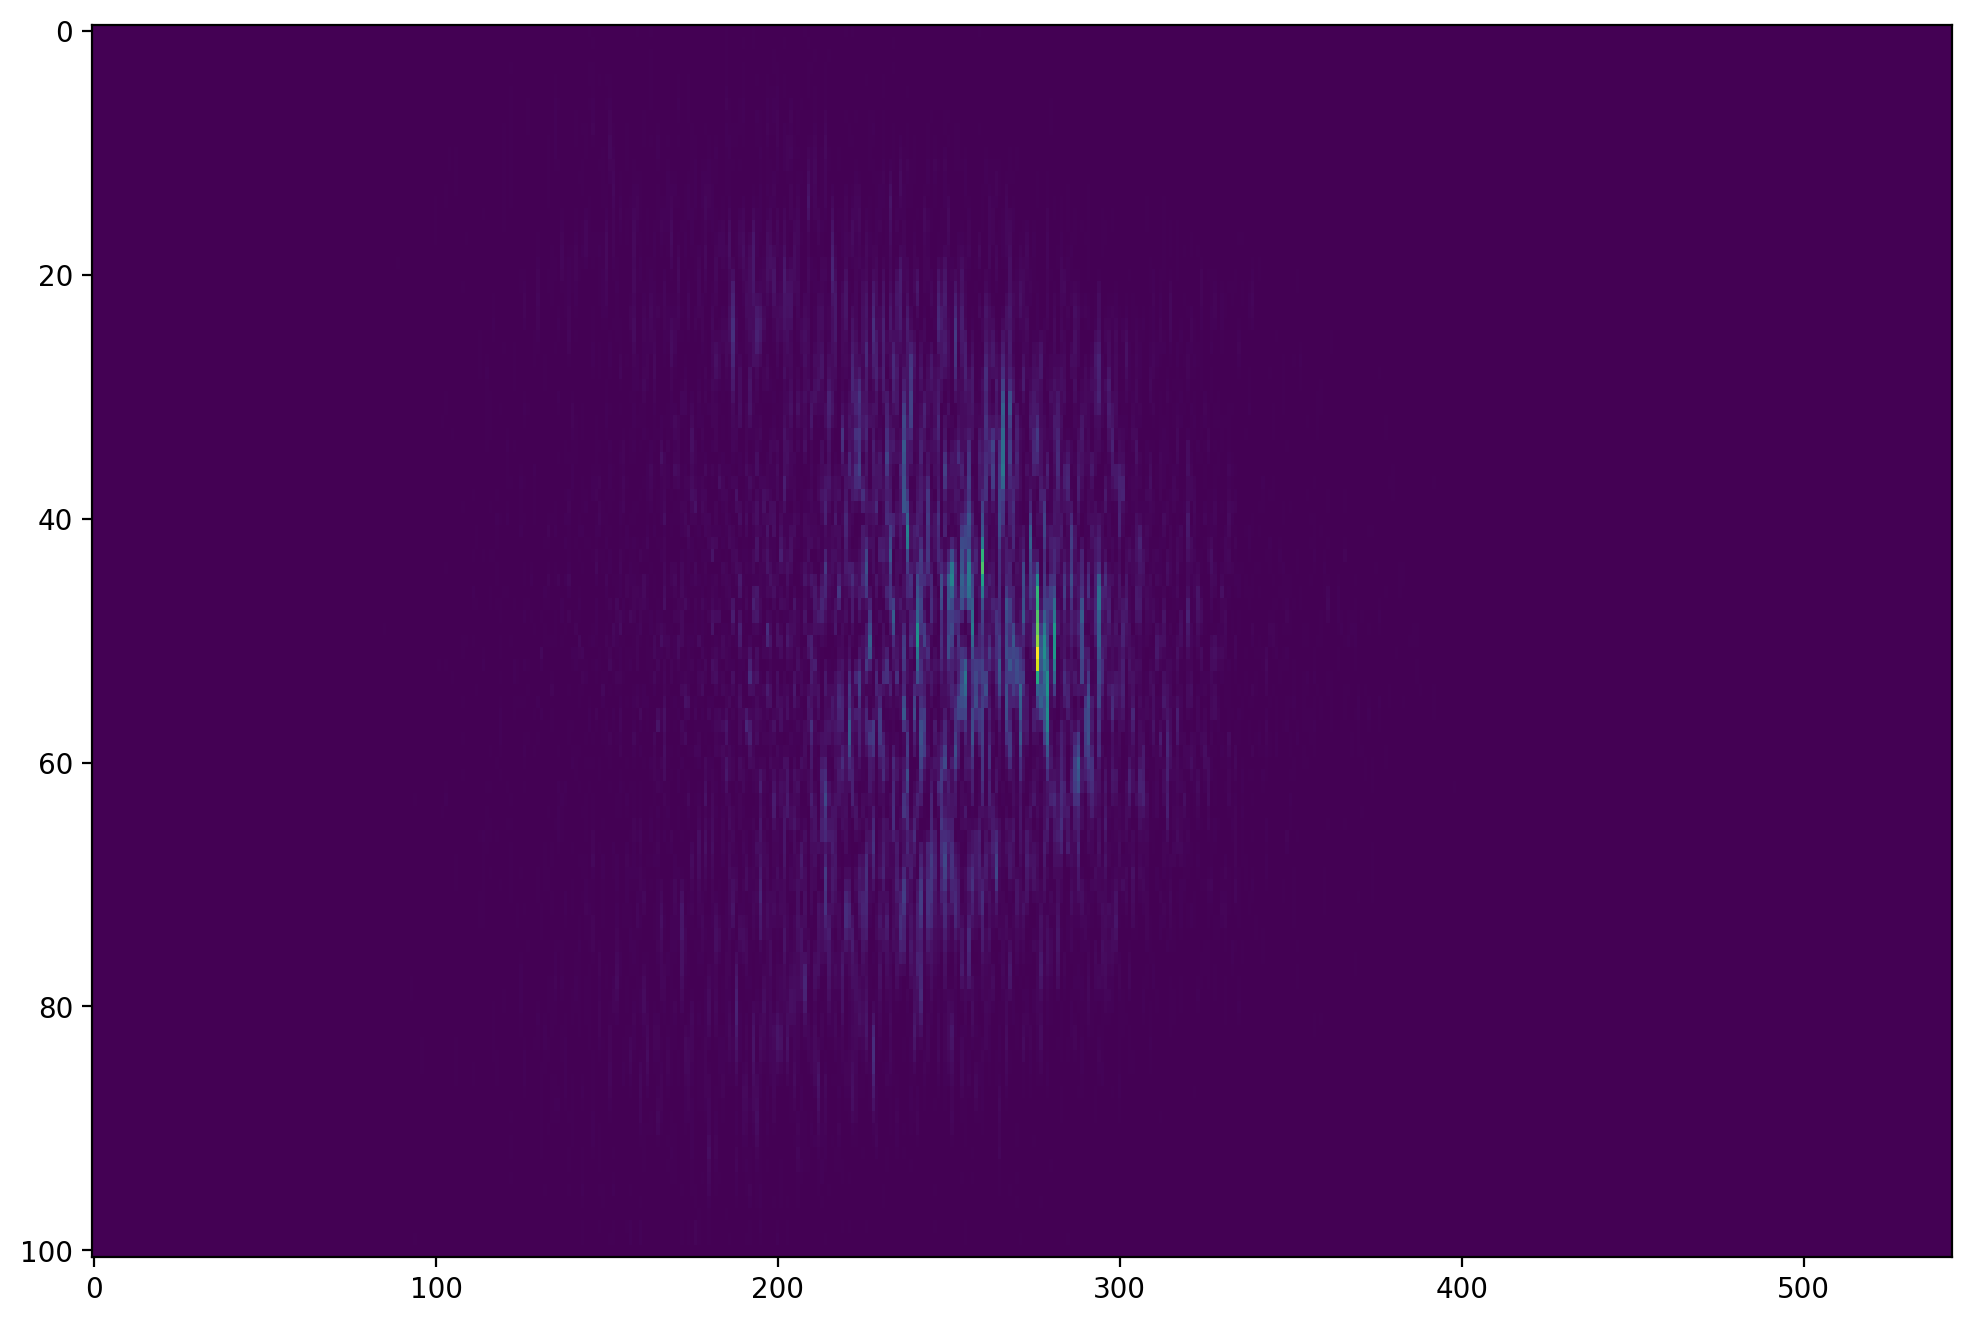

In [14]:
# Plot the center
plt.imshow(dat2[::,:], aspect='auto')

#plt.axis('off');plt.savefig('../../assets/field.png', bbox_inches='tight')

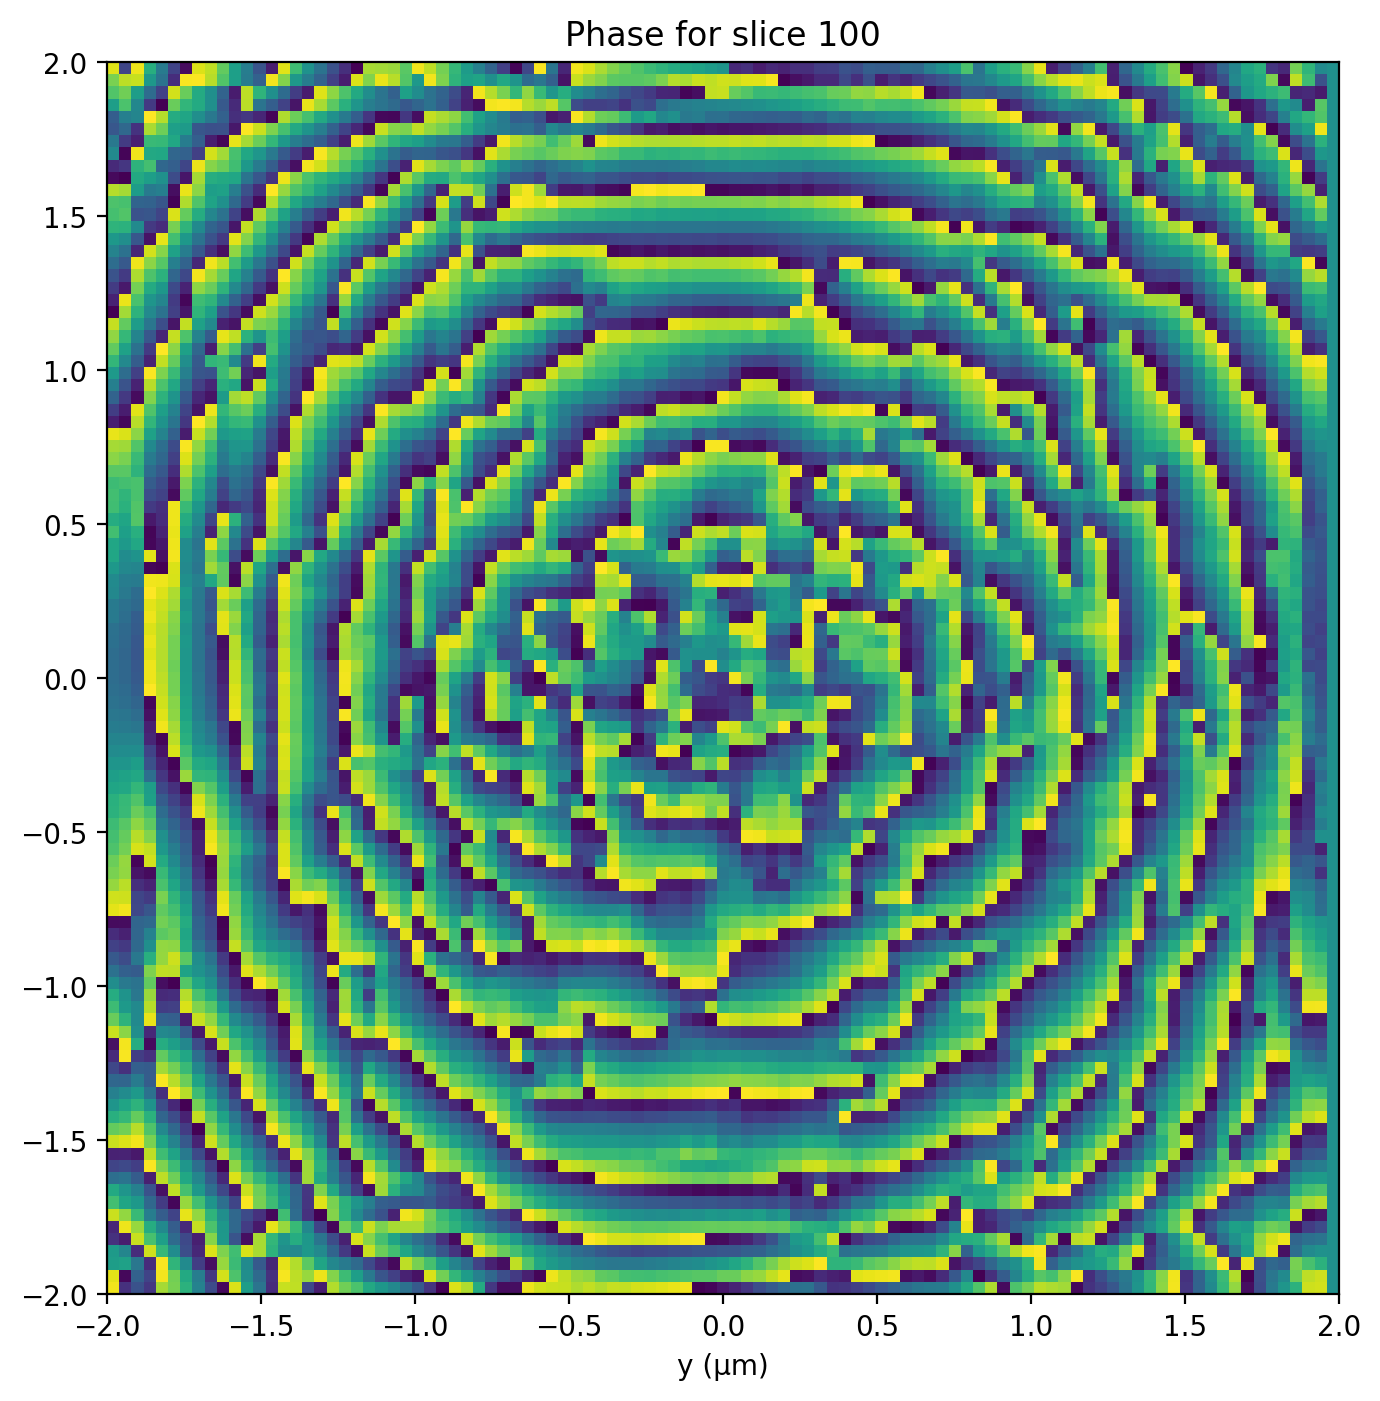

In [15]:
def plot_slice(i=0):
    
    dat = np.angle(DFL[:,:,i])
    
    dx = PARAM['gridsize']*1e6
    plt.xlabel('x (µm)')
    plt.xlabel('y (µm)')
    plt.title(f'Phase for slice {i}')
    plt.imshow(dat.T, origin='lower', extent=[-dx,dx,-dx,dx])
plot_slice(i=100)

In [16]:
from ipywidgets import interact

In [17]:
interact(plot_slice, i=(0,len(DFL[0,0,:])-1, 1))

interactive(children=(IntSlider(value=0, description='i', max=543), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_slice(i=0)>

# Cleanup 

In [18]:
!rm genesis4_wavefront.h5